# Two Step Forecasting for weather and kWh delivered (using GRU)

In this model, I would be implementing a two-step forecast that would first predict the weather for a time in the future and then use the predicted weather data as an input for the kWh Delivered forecasting for the model

In [9]:
# Import necessary packages

In [88]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import GRU, Input, Dense, Dropout
from sklearn.model_selection import train_test_split

In [11]:
# Load the weather data from the weather data folder

In [89]:
folder_path = './caltech_weather_data'
data_frames = []

# Function to safely extract data from JSON
def extract_hourly_data(data):
    historical_data = data.get('historical', {})
    for date, details in historical_data.items():
        hourly_data = details.get('hourly', [])
        for hour_data in hourly_data:
            hour_data['date'] = date
            data_frames.append(hour_data)

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        try:
            with open(file_path) as file:
                data = json.load(file)
                extract_hourly_data(data)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Error processing file {file_name}: {e}")

df = pd.DataFrame(data_frames)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)


weather_df = pd.DataFrame(data_frames)
weather_df['date'] = pd.to_datetime(weather_df['date'])
weather_df.sort_values('date', inplace=True)

# Select relevant features
weather_features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
weather_df = weather_df[weather_features + ['date']]

# Aggregate weather data by day (since kWh data is monthly, daily aggregation should be sufficient)
weather_daily_df = weather_df.groupby('date').mean().reset_index()


In [13]:
# Select relevant features

In [90]:
features = ['temperature', 'wind_speed', 'pressure', 'humidity', 'precip']
df = df[features + ['date']]


In [ ]:
# Normalize the data and split into training and testing sets

In [91]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

# Create sequences for LSTM
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i])

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [46]:
# Build a GRU using the data from the model

In [93]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=len(features)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

Epoch 1/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0228
Epoch 2/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0102
Epoch 3/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0093
Epoch 4/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.0089
Epoch 5/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0086
Epoch 6/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0084
Epoch 7/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0081
Epoch 8/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0081
Epoch 9/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0081
Epoch 10/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0079
Epoch 11/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0078
Epoch 12/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0077
Epoch 13/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0077
Epoch 14/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0077
Epoch 15/25
507/507 ━━━━━━━━━━━━━━━━━━━━ 8

In [17]:
# Evaluate the Model and check for accuracy

In [94]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(y_test)
y_pred_inverse = scaler.inverse_transform(y_pred)

# Evaluate the model for each feature
mae_per_feature = []
mse_per_feature = []

for i, feature in enumerate(features):
    mae = mean_absolute_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mse = mean_squared_error(y_test_inverse[:, i], y_pred_inverse[:, i])
    mae_per_feature.append(mae)
    mse_per_feature.append(mse)
    print(f'{feature.capitalize()} - Mean Absolute Error: {mae}')
    print(f'{feature.capitalize()} - Mean Squared Error: {mse}')


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Temperature - Mean Absolute Error: 2.265269653002421
Temperature - Mean Squared Error: 8.387020701526895
Wind_speed - Mean Absolute Error: 3.0116578857103984
Wind_speed - Mean Squared Error: 14.33562964111097
Pressure - Mean Absolute Error: 1.2669728597005208
Pressure - Mean Squared Error: 3.016678624914752
Humidity - Mean Absolute Error: 9.147197456359864
Humidity - Mean Squared Error: 141.73714974855088
Precip - Mean Absolute Error: 0.11080757616851246
Precip - Mean Squared Error: 0.1878097127478966


In [ ]:
#Plot the results

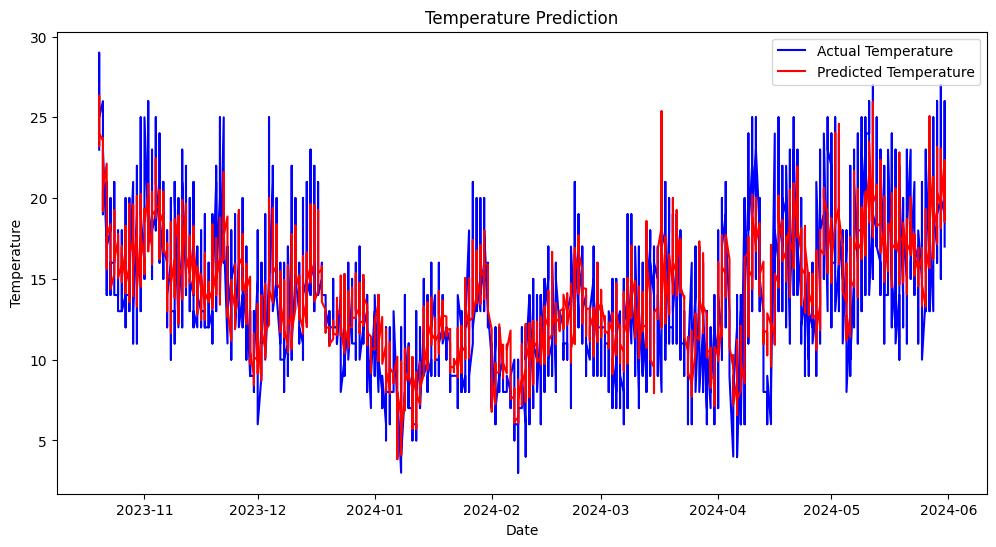

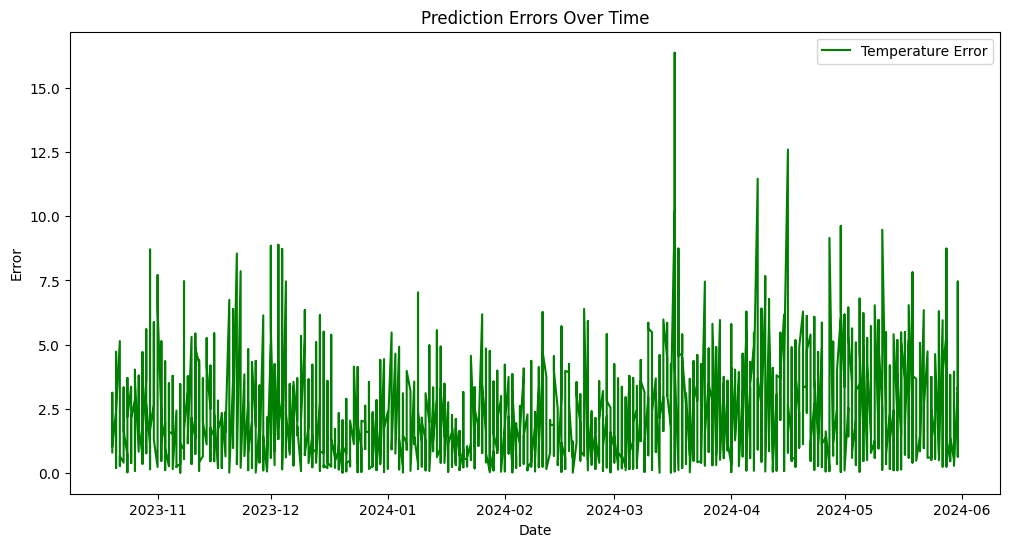

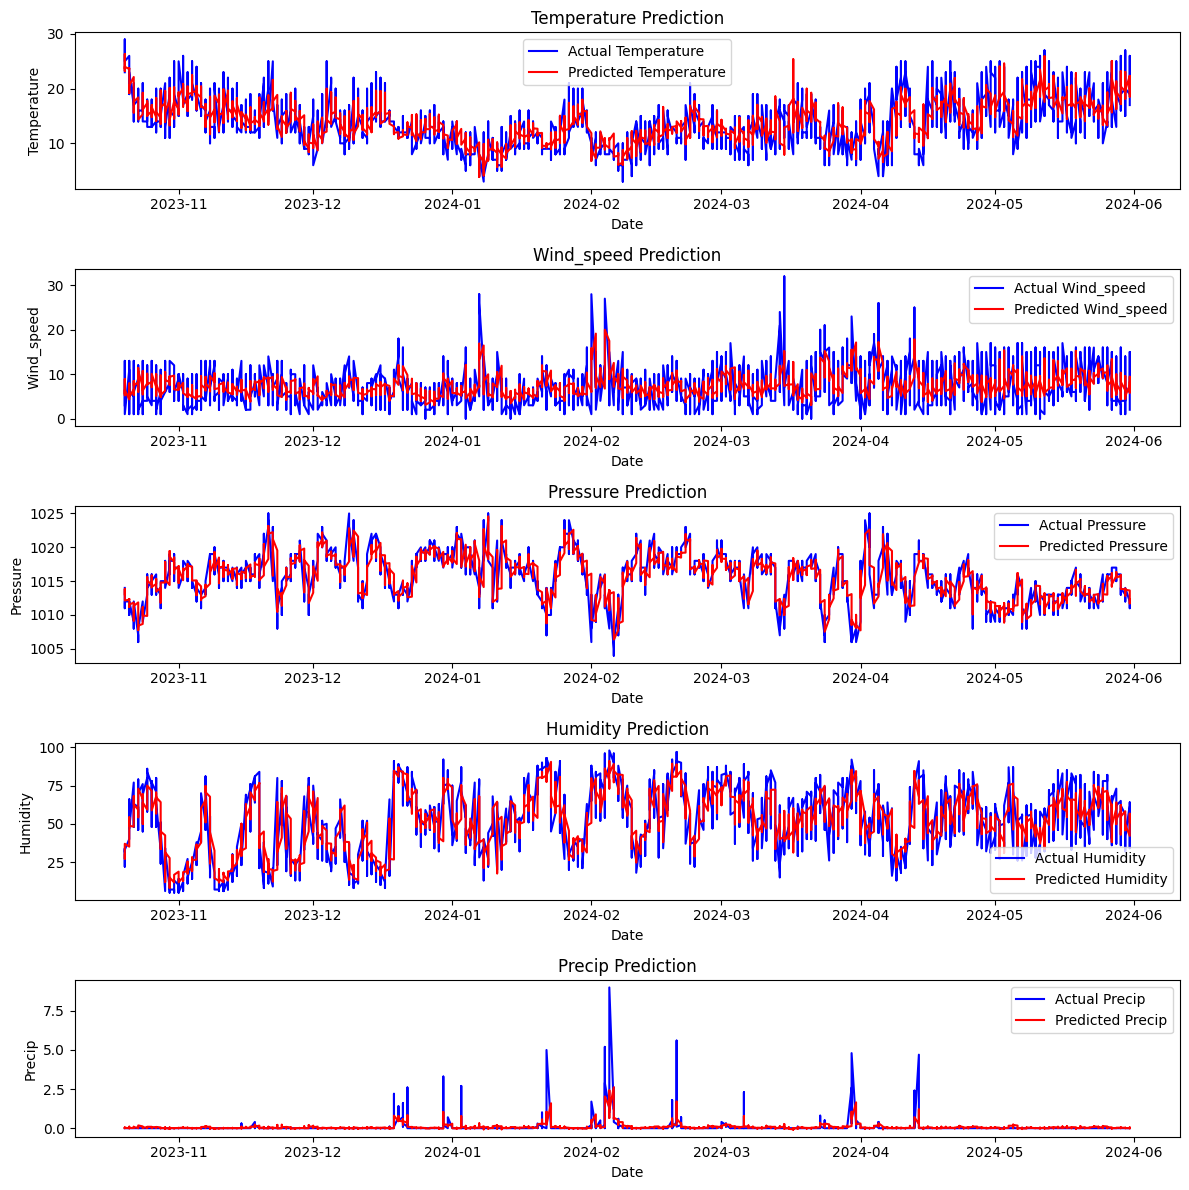

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, 0], color='blue', label='Actual Temperature')
plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, 0], color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Plot the errors over time
errors = np.abs(y_test_inverse - y_pred_inverse)
plt.figure(figsize=(12, 6))
plt.plot(df['date'][train_size+sequence_length:], errors[:, 0], color='green', label='Temperature Error')
plt.title('Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.legend()
plt.show()

# Plot Actual vs Predicted for all features
plt.figure(figsize=(12, 12))
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i+1)
    plt.plot(df['date'][train_size+sequence_length:], y_test_inverse[:, i], color='blue', label=f'Actual {feature.capitalize()}')
    plt.plot(df['date'][train_size+sequence_length:], y_pred_inverse[:, i], color='red', label=f'Predicted {feature.capitalize()}')
    plt.title(f'{feature.capitalize()} Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature.capitalize())
    plt.legend()

plt.tight_layout()
plt.show()

# Second step

Using the forecasted weather data to predict future kWh delivered by electric vehicle charging stations

In [96]:
stations_folder_path = './caltech_stations_data'
stations_data_frames = []

for file_name in os.listdir(stations_folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(stations_folder_path, file_name)
        try:
            station_df = pd.read_csv(file_path)
            stations_data_frames.append(station_df)
        except Exception as e:
            print(f"Error processing file {file_name}: {e}")

ev_data = pd.concat(stations_data_frames, ignore_index=True)
ev_data['date'] = pd.to_datetime(ev_data['month'], format='%Y-%m')
ev_data.drop(columns=['month'], inplace=True)


In [ ]:
# Merge the weather data with the EV charging station data

In [97]:
merged_df = pd.merge(ev_data, weather_daily_df, on='date', how='left')

# Fill missing values (if any) with forward fill method
merged_df.ffill(inplace=True)


In [61]:
# Perform feature engineering

In [99]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_df[weather_features + ['kWhDelivered']])

# Create sequences for LSTM
sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, -1])  # kWhDelivered is the target variable

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(X.shape[0] * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [63]:
# Build the LSTM and plot the results based on aggregating all stations in a location

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0641
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0327
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0303
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0260
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0214
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0202
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0214
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0179
Epoch 9/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0179
Epoch 10/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0182
Epoch 11/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0168
Epoch 12/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0178
Epoch 13/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0154
Epoch 14/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0177
Epoch 15/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0156
Epoc

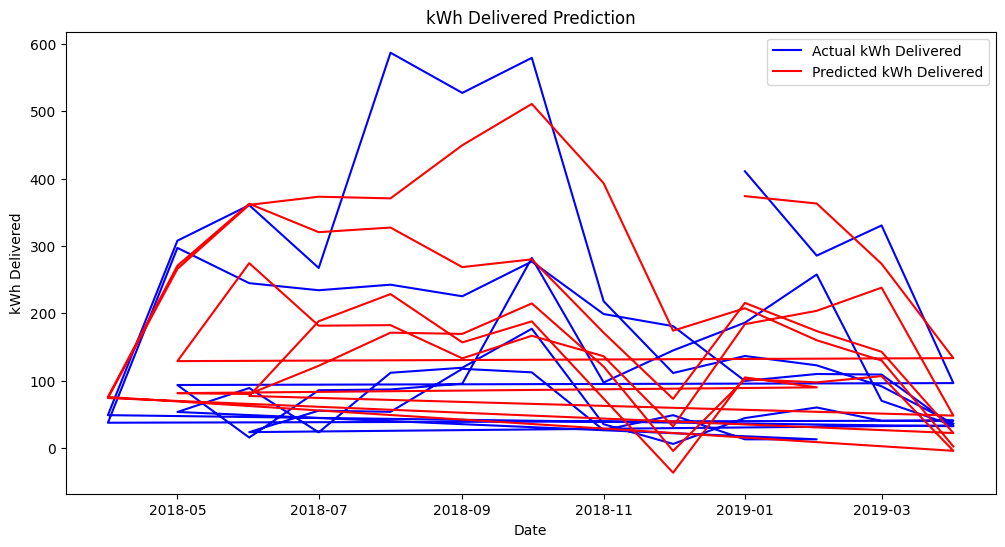

In [100]:
# Define the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = Sequential()
model.add(Input(shape=input_shape))
model.add(GRU(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_test_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], len(weather_features))), y_test.reshape(-1, 1)), axis=1)
)[:, -1]
y_pred_inverse = scaler.inverse_transform(
    np.concatenate((np.zeros((y_pred.shape[0], len(weather_features))), y_pred), axis=1)
)[:, -1]

# Evaluate the model
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'][train_size+sequence_length:], y_test_inverse, color='blue', label='Actual kWh Delivered')
plt.plot(merged_df['date'][train_size+sequence_length:], y_pred_inverse, color='red', label='Predicted kWh Delivered')
plt.title('kWh Delivered Prediction')
plt.xlabel('Date')
plt.ylabel('kWh Delivered')
plt.legend()
plt.show()

In [81]:
# Build the GRU and train individually based on stationID

In [101]:
model_data_dir = './caltech_model_data'
# Initialize lists to store all station data
all_station_data = []

# Loop through each CSV file in the directory
for filename in os.listdir(model_data_dir):
    if filename.endswith(".csv"):
        file_path = os.path.join(model_data_dir, filename)

        # Load the CSV file
        station_data = pd.read_csv(file_path)

        # Inspect the first few rows to determine the format
        print(f"Inspecting date column in {filename}:")
        print(station_data["month"].head())

        # Convert 'month' column to datetime format
        try:
            # Specify the format based on your inspection
            # Example: if the date format is 'YYYY-MM', use format='%Y-%m'
            station_data["month"] = pd.to_datetime(station_data["month"], format='%Y-%m', errors='coerce')
        except Exception as e:
            print(f"Date parsing error for file {filename}: {e}")
            continue

        # Ensure 'kWhDelivered' is numeric
        station_data["kWhDelivered"] = pd.to_numeric(
            station_data["kWhDelivered"], errors="coerce"
        )  # coerce errors to NaN

        # Drop any rows with missing values
        station_data.dropna(inplace=True)

        # Append to list
        all_station_data.append(station_data)

# Concatenate all station data into one DataFrame
data = pd.concat(all_station_data, ignore_index=True)

# Aggregate kWhDelivered by month
monthly_data = data.groupby(["month"])["kWhDelivered"].sum().reset_index()

# Define features (X) and target (y)
features = [
    "MinTemp",
    "MaxTemp",
    "AvgTemp",
    "AvgPrecipitation",
    "AvgHumidity",
    "AvgWindSpeed",
]
target = "kWhDelivered"

# Include aggregated features for merging
aggregated_features = data[features + ["month"]].drop_duplicates(subset=["month"])

# Merge weather data with monthly aggregated kWhDelivered
merged_data = pd.merge(
    monthly_data,
    aggregated_features,
    on="month",
    how="left"
)

# Drop any rows with missing values in merged_data
merged_data.dropna(inplace=True)

# Define features and target for modeling
X = merged_data[features]
y = merged_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print shapes for verification
print(f'Shape of X_train_scaled: {X_train_scaled.shape}')
print(f'Shape of X_test_scaled: {X_test_scaled.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Inspecting date column in 2-39-131-30.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-131-565.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-129-563.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-138-29.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-138-566.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-128-562.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-139-567.csv:
0    2018-05
1    2018-06
2    2018-07
3    2018-08
4    2018-09
Name: month, dtype: object
Inspecting date column in 2-39-130-564.csv:
0    2